In [0]:
%tensorflow_version 1.x

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


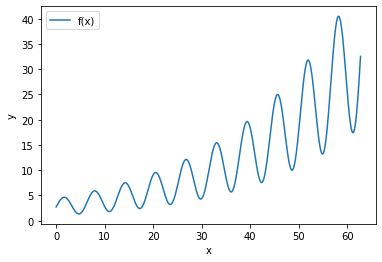

In [3]:
tEnd = 20*math.pi
nSamples = 1000
dt = tEnd/nSamples
x = np.arange(0, tEnd, dt)
y = np.exp(0.5 + x*0.035) * np.sin(x) + np.exp(1 + x*0.04)

plt.plot(x, y, label='f(x)')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')
plt.show()

In [0]:
testIndex = int(nSamples * 0.75)
numFeatures = 1
yReshaped = y.reshape((len(y), numFeatures))

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
yScaled = scaler.fit_transform(yReshaped)

numInputs = 2
train = TimeseriesGenerator(yScaled, yScaled, length=numInputs, batch_size=8, start_index=0, end_index=testIndex)
test = TimeseriesGenerator(yScaled, yScaled, length=numInputs, batch_size=8, start_index=testIndex)

In [5]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(numInputs, numFeatures)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit_generator(train, steps_per_epoch=1, epochs=300, verbose=0, validation_data=test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










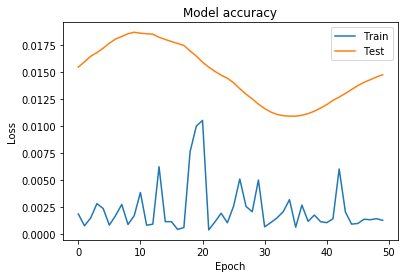

In [7]:
plt.plot(history.history['loss'][250:])
plt.plot(history.history['val_loss'][250:])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [8]:
yScaled.shape

(1000, 1)

In [9]:
trainLoss = model.evaluate_generator(train)
testLoss = model.evaluate_generator(test)
print('Train loss: ', trainLoss)
print('Test loss: ', testLoss)

Train loss:  0.0007574515627259271
Test loss:  0.014763855611231374


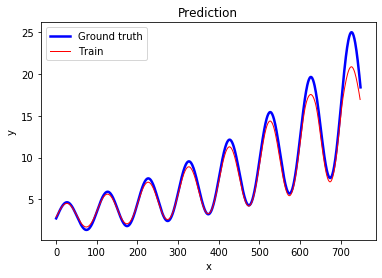

In [10]:
yTrainPredicted = scaler.inverse_transform(model.predict_generator(train))

plt.plot(y[0:testIndex], color='blue', linewidth=2.5)
plt.plot(yTrainPredicted, color='red', linewidth=1.0)
plt.title('Prediction')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Train'], loc='best')
plt.show()

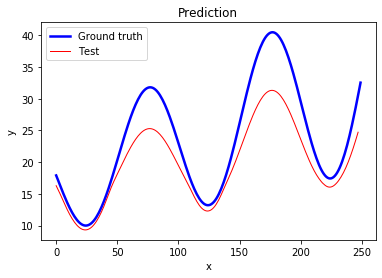

In [11]:
yPredicted = scaler.inverse_transform(model.predict_generator(test))

plt.plot(y[testIndex:], color='blue', linewidth=2.5)
plt.plot(yPredicted, color='red', linewidth=1.0)
plt.title('Prediction')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Test'], loc='best')
plt.show()

In [12]:
last2 = yScaled[testIndex:testIndex+2].reshape(2)
last2

array([0.42304302, 0.41040611])

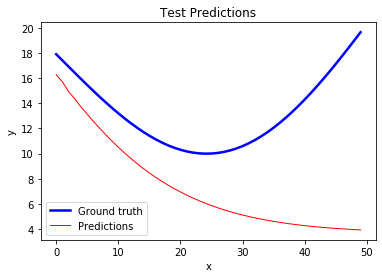

In [13]:
nextX = last2.reshape((1, numInputs, numFeatures))
yValues = []
yPredictions = []
for i in range(50):
    nextY = model.predict(nextX)
    nextX = np.roll(nextX, -1)
    nextX[-1][-1][-1] = nextY[-1][0]
    yPredictions.append(scaler.inverse_transform(nextY)[-1][0])
    yValues.append(y[testIndex+i])

plt.plot(yValues, color='blue', linewidth=2.5)
plt.plot(yPredictions, color='red', linewidth=1.0)
plt.title('Test Predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Ground truth', 'Predictions'], loc='best')
plt.show()